In [1]:
import matplotlib.pyplot as plt
import numpy as np

import regions
import photutils
import astropy.units as u
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from astropy.nddata import CCDData

from skycam_utils.photometry import make_background, make_segmentation_image
from skycam_utils.astrometry import solve_field

In [2]:
hdul = fits.open("data_0000935.fits.gz")
im = hdul[0].data
hdr = hdul[0].header

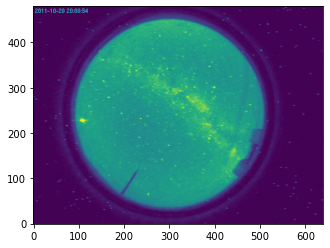

In [4]:
plt.imshow(im, origin='lower')

In [7]:
fov = regions.read_ds9("fov.reg")[0].to_mask(mode='exact')
mmt = regions.read_ds9("mask.reg")[0].to_mask(mode='subpixels')
pole = regions.read_ds9("mask.reg")[1].to_mask(mode='subpixels')

sh = im.shape
mask_image = fov.to_image(sh) - mmt.to_image(sh) - pole.to_image(sh)
mask_image[mask_image <= 0] = np.nan

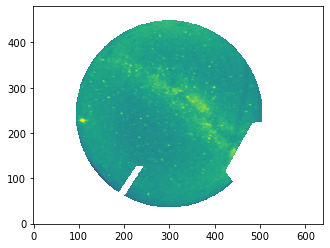

In [8]:
plt.imshow(mask_image * im, origin='lower')

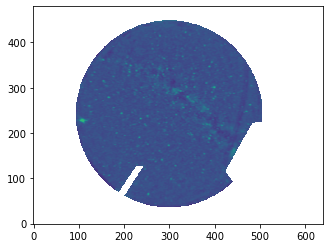

In [15]:
masked_im = np.ma.masked_where(mask_image == np.nan, im)
bkg = make_background(masked_im, boxsize=(7, 7), filter_size=(5, 5))
plt.imshow(im - bkg.background * mask_image, origin='lower')

In [16]:
subt = CCDData(im - bkg.background * mask_image, unit=u.adu)
subt.write("masked_subt.fits", overwrite=True)

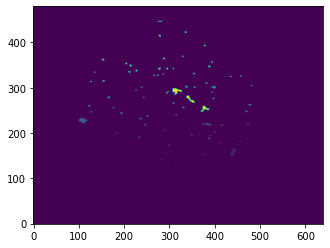

In [17]:
segm = make_segmentation_image(subt.data)
plt.imshow(segm, origin='lower')

In [18]:
cat = photutils.source_properties(subt.data, segm)
t = cat.to_table()
t['obs_mag'] = -2.5 * np.log10(t['source_sum'])
t.sort('obs_mag')

In [20]:
t.keep_columns(['id', 'xcentroid', 'ycentroid', 'source_sum', 'background_mean', 'obs_mag'])
t.write("sources.csv")

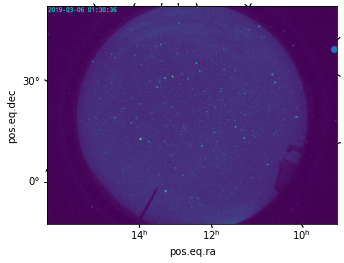

In [55]:
ax = plt.subplot(projection=wcs)
#plt.grid(color='white', ls='solid')
ax.imshow(im)
co_x, co_y = 116.3 * u.deg, 28.0 * u.deg
ax.scatter(co_x, co_y, transform=ax.get_transform('world'))
plt.show()

In [54]:
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 183.250957378  25.6532371745  
CRPIX : 313.896687826  211.121007284  
CD1_1 CD1_2  : -0.271203202065  -0.0358738590292  
CD2_1 CD2_2  : -0.0348827990897  0.2743735958  
NAXIS : 0  0